# Modelling

In [130]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [131]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint
from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split

from SVD import Metrics, RatingSVD, LogisticSVD
from RecData import RecData

## Data Preprocessing

In [135]:
# recs = pd.read_csv('data/recommendations.csv')
# recs = pd.read_csv('data/pruned.csv')
# recs = pd.read_csv('data/2plus.csv')
recs = pd.read_csv('data/full_pruned.csv')

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.sort_values(by=['user_id', 'app_id']).head()

Shape: (1482464, 3)


,app_id,is_recommended,user_id
420790,12210,True,240
675882,22380,True,240
246231,239140,True,240
539676,251570,True,240
521289,270880,True,240


In [136]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# # del recs

# start_time = time.time()
# print("Creating splits...")
# train_data, test = rec_data.train_test_split(test_size=0.2)
# print("First split done.")
# train_data, val = train_data.train_test_split(test_size=0.2)
# print("Done creating splits in", time.time() - start_time, "seconds")

In [137]:
random.seed(42)
np.random.seed(42)
rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

# del recs

print("Creating splits...")
train_data, val = rec_data.leave_k_out_split(k=1, create_val=False)
print("Done creating splits.")

Creating utility matrix...
Done utility matrix.
Creating splits...
Done user 1 / 63175
Done user 10001 / 63175
Done user 20001 / 63175
Done user 30001 / 63175
Done user 40001 / 63175
Done user 50001 / 63175
Done user 60001 / 63175
Done creating splits.


In [138]:
del rec_data
del item_data
del titles

## Ranker

This was used as a postprocessing step after using item-knn for candidate generation. Was not able to get good results.

In [139]:
# train = train_data.generate_dataframe()
# X_train = train[['app_id', 'user_id']]
# y_train = train['is_recommended'].to_numpy()

# X_train = X_train.sort_values(by='user_id')
# counts = X_train['user_id'].value_counts(sort=False)
# X_train = X_train[['app_id']]

In [140]:
# ranker = LGBMRanker(n_estimators=300, random_state=42, objective='lambdarank')
# ranker = ranker.fit(X_train, y_train, group = counts.values, categorical_feature=['app_id'],
#                     eval_set=[(X_train, y_train)], eval_group=[counts.values], 
#                     eval_at=20)

## Training SVD

Epoch 0/Training loss: 0.44893240148727287/Validation loss: 0.446880214669421/Time: 7.03 seconds
Epoch 1/Training loss: 0.4319514626413884/Validation loss: 0.4324822038536999/Time: 7.04 seconds
Epoch 2/Training loss: 0.42207961796575905/Validation loss: 0.42468981613958834/Time: 6.74 seconds
Epoch 3/Training loss: 0.4145296696329102/Validation loss: 0.4189054175124522/Time: 6.8 seconds
Epoch 4/Training loss: 0.40825745555678/Validation loss: 0.41403574218962674/Time: 6.68 seconds
Epoch 5/Training loss: 0.40278987299052094/Validation loss: 0.40986453899120523/Time: 7.44 seconds
Epoch 6/Training loss: 0.3979827032052192/Validation loss: 0.4061776632195162/Time: 6.77 seconds
Epoch 7/Training loss: 0.39363085659445163/Validation loss: 0.4028261481115581/Time: 6.89 seconds
Epoch 8/Training loss: 0.3897106044044752/Validation loss: 0.39991363900664956/Time: 7.04 seconds
Epoch 9/Training loss: 0.386125550291084/Validation loss: 0.3970452487800476/Time: 6.77 seconds
Epoch 10/Training loss: 0.3

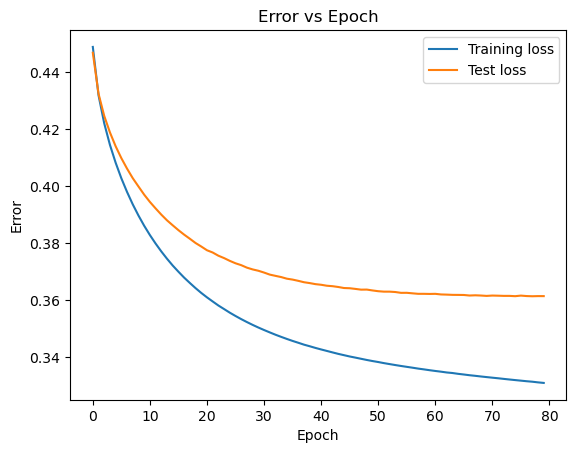

Validation rmse 0.3363220889435754


In [141]:
# for pruned, epoch: 80, lr:0.01, reg:0.02, k=100
# for 2plus, epoch: 80, lr:0.01, reg:0.02, k=100

EPOCHS = 50

random.seed(42)
np.random.seed(42)

# # Fit and predict with svd
# svd_predictor = RatingSVD(
#     train_data.get_num_users(), train_data.get_num_items(), 2, k=20, 
#     learning_rate=0.001, C=0.02)
# svd_predictor.fit(train_data.get_matrix(), 100, validation_set=val, early_stop=False)
svd_predictor = LogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=100, 
    learning_rate=0.01, C=0.04)
svd_predictor.fit(train_data.get_matrix(), 80, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training loss')
plt.plot(range(len(val_errors)), val_errors, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Validation rmse", rmse)

We can now continue to train if we believe the model is still underfitting.

In [96]:
svd_predictor.continue_fit(5, early_stop=False)

Epoch 0/Training loss: 0.3310048729505605/Validation loss: 0.3668407408068704/Time: 6.42 seconds
Epoch 1/Training loss: 0.3308785212570457/Validation loss: 0.36668613746672435/Time: 6.47 seconds
Epoch 2/Training loss: 0.3307778518988458/Validation loss: 0.36682711561881687/Time: 6.44 seconds
Epoch 3/Training loss: 0.33066106574172127/Validation loss: 0.3668262213547057/Time: 6.41 seconds
Epoch 4/Training loss: 0.3305361367134747/Validation loss: 0.3668876285863532/Time: 6.47 seconds


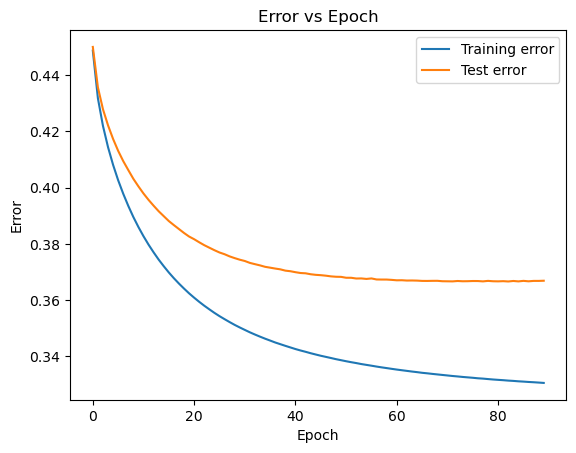

Test rmse 0.3389991203215268


In [98]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

We compute similarities for item-knn.

In [143]:
svd_predictor.compute_sims()

Computing similarities...
Upto row 1 / 2215
Upto row 201 / 2215
Upto row 401 / 2215
Upto row 601 / 2215
Upto row 801 / 2215
Upto row 1001 / 2215
Upto row 1201 / 2215
Upto row 1401 / 2215
Upto row 1601 / 2215
Upto row 1801 / 2215
Upto row 2001 / 2215
Upto row 2201 / 2215
Done computing similarities in 459.26107907295227 seconds


## Preparing for Production

In [183]:
svd_predictor.prep_for_item_knn()
train_data.prep_for_item_knn()

## Saving the model

In [184]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([train_data, svd_predictor], file)
print("Done saving model.")

Saving model...
Done saving model.


## Tests

In [2]:
with open('saved_models/2023-7-8-12-15-13_0-37.pkl', 'rb') as file:
    train_data, svd_predictor = pickle.load(file)

### Testing Rerank

In [10]:
# data.search_title('forza')

In [11]:
# filtered = svd_predictor.items_top_n([(286, 1)])
# app_ids = []
# for item_index in filtered:
#     app_ids.append(data.index_to_item_id(item_index))
# df = pd.DataFrame({'app_id': app_ids})
# predictions = ranker.predict(df)
# df['relevance'] = predictions
# df.head()
# df = df.sort_values(by='relevance', ascending=False)
# df.head()

In [12]:
# pprint([[data.index_to_title(data.item_id_to_index(i)) for _, i, _ in df.itertuples()]][0][:20])

### Testing Performance

Checking recall.

In [ ]:
start_time = time.time()
print("Computing recall...")
svd_predictor.compute_recall(val)
print("Done computing recall in", time.time() - start_time, "seconds")

Checking item-based knn.

In [181]:
train_data.search_title('morrow')

[('The Elder Scrolls III: Morrowind® Game of the Year Edition', 286)]

In [182]:
top = svd_predictor.items_knn([(286, 1)], n=10)
pprint([(sim, train_data.index_to_title(index)) for sim, index in top])

[(0.3909011480578025, 'SYNTHETIK: Legion Rising'),
 (0.3841846126585478, 'Project Zomboid'),
 (0.37059030387893616, 'Prey'),
 (0.358146951708476, 'Baba Is You'),
 (0.35381420271035313,
  'The Elder Scrolls IV: Oblivion® Game of the Year Edition'),
 (0.3432573234220497, 'Noita'),
 (0.3386980475254265, 'Lakeview Cabin Collection'),
 (0.3266681055135028, 'Sphinx and the Cursed Mummy'),
 (0.3248535952606597, 'Star Wars: Battlefront 2 (Classic 2005)'),
 (0.3184148814972455, 'Roads of Rome')]


Checking collaborative filtering.

In [167]:
j = 0

# Test top-n list for user j
top_n = svd_predictor.top_n(j, 1000)
print("Predicted top n:")
pprint([index for r, index in top_n][0])
pprint([(r, train_data.index_to_title(index)) for r, index in top_n][0:10])

# User j true top n list
print("True top n:")
true_top = train_data.top_n(j, 5000)
pprint([train_data.index_to_title(index) for _, index in true_top])

Predicted top n:
851
[(0.9968352281650713, 'Portal 2'),
 (0.9946677512593055, 'A Hat in Time'),
 (0.9908751027460545, 'Terraria'),
 (0.988362185522955, 'POSTAL 2'),
 (0.9852212159579746, 'Thief™ II: The Metal Age'),
 (0.9849846623480601, 'Mafia II (Classic)'),
 (0.9843172938505443, 'Lil Gator Game'),
 (0.9820391254008433, 'DOOM (1993)'),
 (0.980323903775534, 'Gunpoint'),
 (0.980298526943475, 'Glass Masquerade')]
True top n:
['Brotato',
 'CarX Drift Racing Online',
 "No Man's Sky",
 'Guild Wars 2',
 'DARK SOULS™: REMASTERED',
 'Halo: The Master Chief Collection',
 'MONSTER HUNTER RISE',
 'OUTRIDERS',
 'Red Dead Online',
 'Black Desert',
 'Cookie Clicker',
 'Squad',
 'Muse Dash',
 'STAR WARS™ Battlefront™ II',
 'Lara Croft and the Guardian of Light',
 'TrackMania² Stadium',
 'Forsaken World: Gods and Demons',
 'The Witcher® 3: Wild Hunt',
 'Far Cry® 5',
 'Call of Duty®: Modern Warfare® II',
 'Hell Let Loose',
 'PAYDAY 2',
 'Call of Duty®: WWII',
 'Ring of Elysium']


Testing partial fit below.

In [46]:
train_data.search_title('GunPoint')

[('Gunpoint', 1066)]

In [21]:
prefs = [(147, 1), (325, 1)]
# prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, train_data.index_to_title(index), pref) for index, pref in prefs])
prefs = train_data.create_prefs(prefs)    

[(147, 'The Elder Scrolls V: Skyrim Special Edition', 1),
 (325, 'Slay the Spire', 1)]


In [22]:
epochs = 1

start_time = time.time()
svd_predictor.partial_fit(prefs, epochs=epochs)
print("Completed partial fit in", time.time() - start_time, "seconds")

Epoch 0/Time: 6.88 seconds
Completed partial fit in 7.875029563903809 seconds


In [77]:
top_n = svd_predictor.top_n(svd_predictor._num_users - 1, 10)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

Predicted top n
[(0.9982461964946436, 'Portal 2'),
 (0.9975848280674955, 'Lil Gator Game'),
 (0.9972566028210699, 'A Hat in Time'),
 (0.9970133024919003, 'Mafia II (Classic)'),
 (0.9965968665801356, 'Princess Maker 2 Refine'),
 (0.9960268078775195, 'Drox Operative'),
 (0.9959851745120898, 'Turing Complete'),
 (0.9957737377324469, 'The Case of the Golden Idol'),
 (0.9956506885362327, 'Thief™ II: The Metal Age'),
 (0.9952304365799456, 'Through the Ages')]
